In [184]:
import os
import sys
sys.path.append('../../')
sys.path.append('../../lib')


import numpy as np
import random
import scipy.signal as ss
import matplotlib
import matplotlib.pyplot as plt

from math import *
from pylab import *
from mpdaf import *

from mpdaf.obj import Cube
from mpdaf.obj import Image
from mpdaf.obj import Spectrum
from mpdaf.obj import WCS
from mpdaf.obj import WaveCoord
from mpdaf.sdetect import SourceList

import shade_main,parameters,detection,array_tools,preprocessing,postprocessing,function_Image
reload(shade_main)
reload(parameters)
reload(detection)
reload(array_tools)
reload(preprocessing)
reload(postprocessing)
reload(function_Image)
%matplotlib inline
rcParams['image.cmap']='coolwarm'
rcParams['image.origin']='lower'
rcParams['image.interpolation']='nearest'
rcParams['figure.figsize']=(10,10)

In [63]:
src_list = SourceList.from_path('/home/floriane/HDFS/sources/sources_1.24/after_lyana/')

In [185]:
listID=[]
for src in src_list:
    listID.append(src.id)

In [186]:
len(listID)

68

In [209]:
listID=[43,]#43, 92, 95, 139]

#cube=Cube('/home/floriane/HDFS/DATACUBE-HDFS-v1.24.fits')
cube=Cube('/home/floriane/HDFS/DATACUBE-HDFS-v1.24_VAR_estimated.fits')

In [210]:
### choix des paramètres, 
# sim=False : il ne s'agit pas d'une source simu, on permet
# lmbdaShift : variation max dans la famille de spectres de tests créés (on va de -lmbdaShift à + lmbdaShift)
# LW : demi-largeur de la zone étudié en lmbda
# SW : demi-largeur de la zone étudié en spatial
params=parameters.Params(sim=False,lmbdaShift=7,LW=15,SW=25)

### creation de l'objet méthode à partir de la liste d'ID, cela permet de construire des sources plus grandes que celles obtenues dans le catalogue
shade1=shade_main.SHADE(listID=listID,params=params,catalog='/home/floriane/HDFS/Catalog_HDFS_v1p0.fits',cube=cube) 

#preprocessing avec parametrisation : ici,on fait la soustraction du continu par filtre median, et on force le preprocessing
paramsPreProcess=parameters.ParamsPreProcess(methodRC='medfilt',forceProcess=True)
shade1.preprocess(paramsPreProcess=paramsPreProcess)


### Detection
shade1.detect()

### PostProcess
paramsPostProcess=parameters.ParamsPostProcess(threshold=0.01,
                 FDR=True,
                 qvalue=True,
                 newSource=True,)
shade1.postprocess(paramsPostProcess=paramsPostProcess)

In [211]:
len(shade1.listResultSources)

1

In [190]:
#for src in shade1.listResultSources:
#    src.write('/home/floriane/HDFS/sources/sources_1.24/after_shade/shade_%s.fits'%src.id)

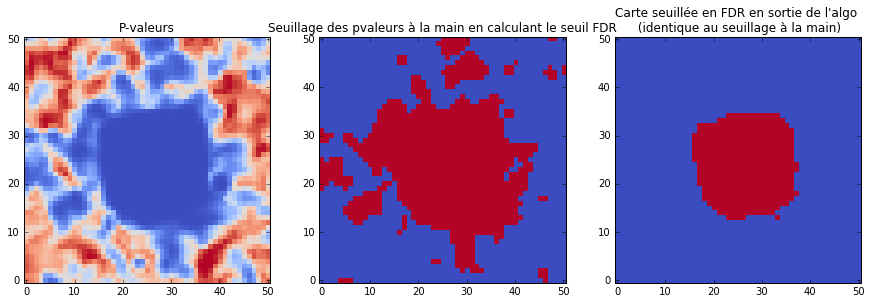

In [213]:
rcParams["figure.figsize"]=(15,15)
plt.subplot(131)
plt.title('P-valeurs')
plt.imshow(shade1.listResultSources[0].images['DET_STAT'].data)
plt.subplot(132)
plt.title(u'Seuillage des pvaleurs à la main en calculant le seuil FDR')
#on calcule le seuil à appliquer aux pvaleurs pour avoir un FDR de 0.02
seuil=shade1.postprocessing.corrPvalueBH(shade1.listResultSources[0].images['DET_STAT'].data,0.5)
plt.imshow(shade1.listResultSources[0].images['DET_STAT'].data<seuil)
plt.subplot(133)
plt.title(u'Carte seuillée en FDR en sortie de l\'algo \n (identique au seuillage à la main)')
plt.imshow(shade1.listResultSources[0].images['DET_BIN_ALL'].data)

In [202]:
# On refait le postprocess, cette fois-ci avec un seuil en PFA et non en FDR
paramsPostProcess=parameters.ParamsPostProcess(threshold=0.02,
                 FDR=False,
                 qvalue=True,
                 newSource=True,)
shade1.postprocess(paramsPostProcess=paramsPostProcess)

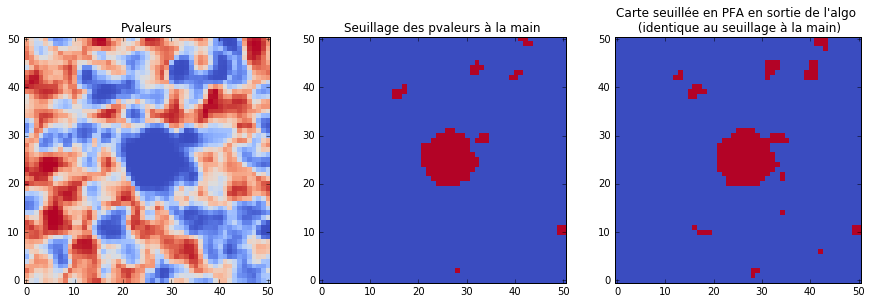

In [203]:
rcParams["figure.figsize"]=(15,15)
plt.subplot(131)
plt.title('Pvaleurs')
plt.imshow(shade1.listResultSources[0].images['DET_STAT'].data)
plt.subplot(132)
plt.title(u'Seuillage des pvaleurs à la main')
plt.imshow(shade1.listResultSources[0].images['DET_STAT'].data<0.01)
plt.subplot(133)
plt.title(u'Carte seuillée en PFA en sortie de l\'algo \n (identique au seuillage à la main)')
plt.imshow(shade1.listResultSources[0].images['DET_BIN_ALL'].data)

## Qvaleurs 
les qvaleurs sont l'équivalents des pvaleurs mais pour le FDR au lieu de la PFA (en gros ça veut dire que si tu veux un FDR de 0.01 tu peux direct seuiller la carte de qvaleurs à 0.01 (comme lorsque tu veux une PFA de 0.01 tu peux direct seuiller les pvaleurs à 0.01)
Pour l'instant la carte de Q-valeurs ne correspond pas parfaitement à mon calcul FDR (si tu compares les cartes seuillés ça colle pas tout à fait) mais la carte des Qvaleurs me semble intéressante, si tu veux regarder ce que ça donne pour d'autres objets...

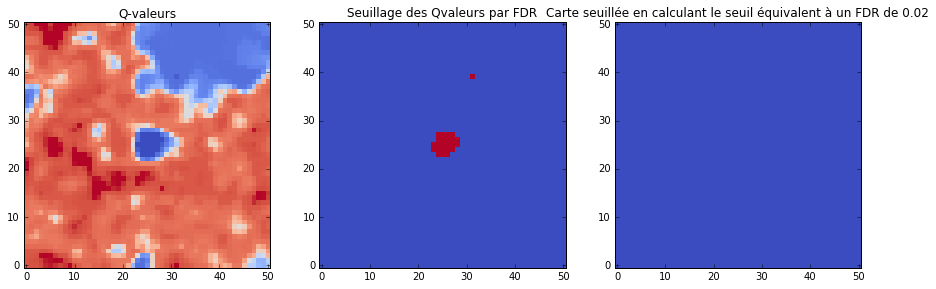

In [197]:
rcParams["figure.figsize"]=(15,15)
plt.subplot(131)
plt.title('Q-valeurs')
plt.imshow(shade1.listResultSources[0].images['DET_QSTAT'].data)
plt.subplot(132)
plt.title(u'Seuillage des Qvaleurs par FDR')
plt.imshow(shade1.listResultSources[0].images['DET_QSTAT'].data<0.02)
plt.subplot(133)
plt.title(u'Carte seuillée en calculant le seuil équivalent à un FDR de 0.02')
seuil=shade1.postprocessing.corrPvalueBH(shade1.listResultSources[0].images['DET_STAT'].data,0.02)
plt.imshow(shade1.listResultSources[0].images['DET_STAT'].data<seuil)

In [ ]:
shade1